(ch5:multicovar)=
# Network Models with Network Covariates

To conclude your learnings on network models, we're going to delve into a common problem in machine learning known as the classification problem. For each piece of data $x_i$ in your sample, you might often have another piece of information $y_i$ associated with this data which you think is associated with the data $x_i$ in some way. This additional information $y_i$ is known as the **class** of the $i^{th}$ item, and is a *categorical variable* which takes values between $1$ and $Y$, where $Y$ is the total number of possible classes in your experiment. A **categorical variable** is a variable that can take one of a fixed set of possible values. Consider the case where you have the heights of a selection of people and aliens for a hypothetical sample. The data $x_i$ is the height of each individual $i$. $y_i$ indicates whether the $i^{th}$ individual is a person (1) or an alien (2). $y_i$ is a categorical variable because you chose people to be $1$ and aliens to be $2$ arbitrarily, and the total number of classes $Y$ is $2$. Your question of interest is the extent to which you can *predict* the class for each individual (person or alien) using only their height $x_i$. 

Now let's imagine that you have a collection of networks representing the brains of $100$ individuals $500,000$ years into the future (let's hope humanity makes it that long!). These individuals are all either humans who have persisted with life-as-normal on earth (earthlings), or astronauts who left for a planet with a different set of prominent colors and light content from Earth. The environment was extremely harsh, so there were evolutionary pressures on your astronauts towards people whose eyes could better adapt to the different set of colors and light on the new planet. Each network has $5$ nodes, representing the sensory functions and modalities of the brain: the area responsible for sight, the area responsible for language, the area responsible for hearing/emotional expression, the area responsible for thinking/movement, and the area responsible for basic survival functions (such as heartbeat and breathing). Edges represent whether pairs of brain areas can pass information to one another. In this case, you have observed pairs of data $(A^{(m)}, y_m)$, for $m$ from $1$ to $M=100$. Each adjacency matrix $A^{(m)}$ is a $5 \times 5$ matrix, and the indicator variable $y_m$ takes the value $1$ if the $m^{th}$ individual is an earthling, or $2$ if the $m^{th}$ individual is an astronaut. In this case, you want to predict the class for each individual (earthling or astronaut) using only their adjacency matrix $A^{(m)}$. You can see two example networks for the earthlings and the astronauts below:

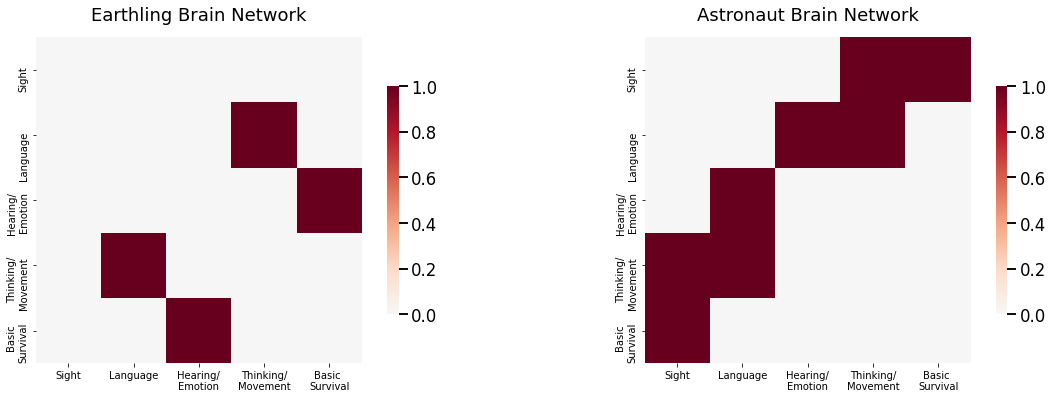

In [3]:
from graspologic.plot import heatmap
import numpy as np
import matplotlib.pyplot as plt
from graphbook_code import ier

n = 5
P_hum = np.random.beta(size=n*n, a=3, b=8).reshape(n, n)
P_hum = (P_hum + P_hum.T)/2
P_hum = P_hum - np.diag(np.diag(P_hum))

nodenames = ["Sight", "Language", "Hearing/\nEmotion", "Thinking/\nMovement", "Basic \nSurvival"]
E = np.array([[0,1,1,1,1], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0]], dtype=bool)
P_ast = np.copy(P_hum)

P_ast[E] = np.sqrt(P_ast[E])  # probabilities for signal edges are higher in astronauts than humans

Ahum = ier(P_hum, loops=False, directed=False)
Aast = ier(P_ast, loops=False, directed=False)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

heatmap(Ahum, ax=axs[0], xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5],
                yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], title="Earthling Brain Network")
heatmap(Aast, ax=axs[1], xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5],
                yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], title="Astronaut Brain Network")
axs[0].set_xticklabels(nodenames);
axs[1].set_xticklabels(nodenames);
axs[0].set_yticklabels(nodenames);
axs[1].set_yticklabels(nodenames);

Remember that to devise a statistical model, you suppose each piece of data in your sample is an observation of a corresponding random variable. When you were dealing with multiple network models, this meant that for each network $A^{(m)}$ there was a random network $\mathbf A^{(m)}$, and that this random network was the data-generating process that we were observing $A^{(m)}$ from. Here, for each data pair $(A^{(m)}, y_m)$, there exists a corresponding random network $\mathbf A^{(m)}$ and a corresponding random class $\mathbf y_m$, where $(A^{(m)}, y_m)$ is a sample of $(\mathbf A^{(m)}, \mathbf y_m)$. So, for your multiple network model with covariates, you seek a model which describes both $\mathbf A^{(m)}$ and $\mathbf y_m$.

(ch5:multicovar:ssn)=
## Signal Subnetwork Model

As it turns out, these astronauts are remarkably similar to the eathlings, except for one piece of information: the connections between the occipital lobe and all other lobes for the astronauts have a much higher chance of being connected. In other words, the **subnetwork** comprised of edges incident the occipital lobe carry the *signal disparity* between human and astronaut brains. What this means is that, if you were to just compare the adjacency matrices themselves, you would end up looking at a lot of *noise*, or edges which do not show any difference between the humans and the astronauts. In a fixed sample of earthlings and astronauts, you might find disparities between these noise edges, but these disparities are just because of the particular sample of humans and astronauts that you chose and are not representative of actual differences. Rather, what you want to do is identify the subset of edges and corresponding nodes, called the *signal subnetwork*, which actually carry the *signal*, the set of edges which show real differences between the earthlings and the astronauts. As you can see below, the probability matrices between the humans and the astronauts are the same except for the set of edges which have a node in the area which controls eyesight:

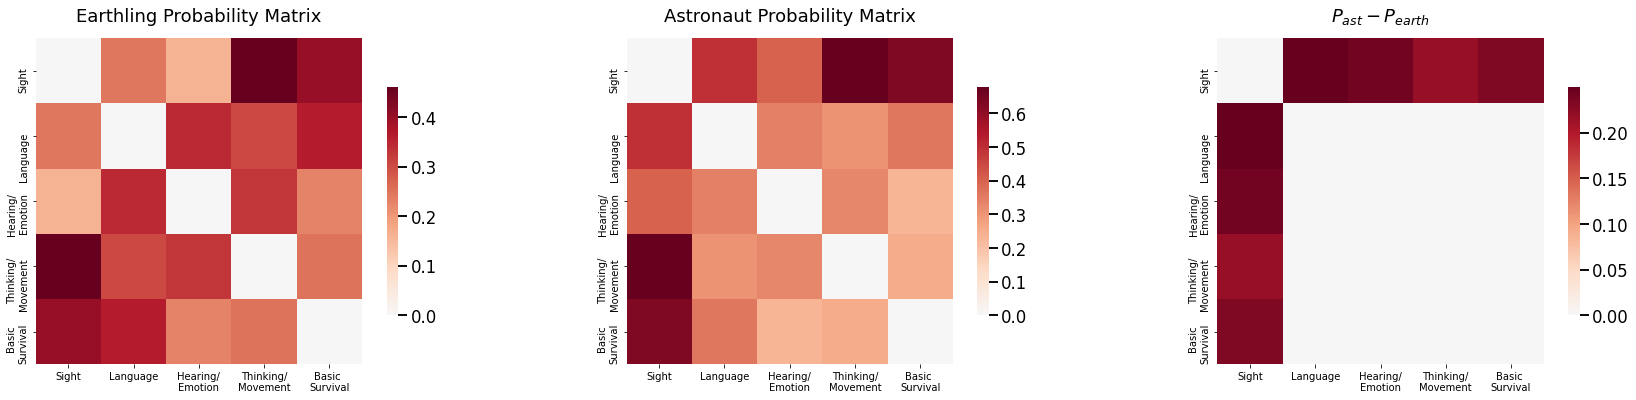

In [4]:
def plot_prob(X, title="", nodename="Student", nodetix=None,
             nodelabs=None, ax=None):
    if (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1, annot=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return


fig, axs = plt.subplots(1, 3, figsize=(30, 6))

heatmap(P_hum, ax=axs[0], xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5],
                yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], title="Earthling Probability Matrix")
heatmap(P_ast, ax=axs[1], xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5],
                yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], title="Astronaut Probability Matrix")
heatmap(P_ast - P_hum, ax=axs[2], xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5],
                yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], title="$P_{ast} - P_{earth}$")
axs[0].set_xticklabels(nodenames);
axs[1].set_xticklabels(nodenames);
axs[0].set_yticklabels(nodenames);
axs[1].set_yticklabels(nodenames);
axs[2].set_xticklabels(nodenames);
axs[2].set_yticklabels(nodenames);

We will attempt to do this using the *signal subnetwork model*, which is a statistical model for adjacency matrices where you have a covariate. When you want to later decide whether a network is from an earthling or an astronaut, you want to look *only* at the signal subnetwork, and ignore the rest of the network entirely.

For the SSN model, the core idea is that for each edge in the network, the probability of an edge existing (or not existing) is either the same, or different, between the two classes. You capture this idea using the **signal subnetwork**. For an edge $(i, j)$ for classes $y$ (either $0$ or $1$), you will use the notation $p_{ij}^y$ to denote the probability of an edge existing in class $y$. 

### Signal Subnetwork

The **signal subnetwork** is a collection of edges $\mathcal S$, which has edges $(i,j)$ where $i$ and $j$ are nodes in the network between $1$ and $n$, such that the following two conditions hold:

1. For each edge which is in the signal subnetwork, the probability of an edge existing differs between classes $0$ and $1$. That is, if an edge $(i, j)$ is in the signal subnetwork $\mathcal S$, then there exist two classes $y$ and $y'$ where $p_{ij}^{y} \neq p_{ij}^{y'}$.
2. For each edge which is *not* in the signal subnetwork, the probabilitty of an edge existing is the *same* between classes $0$ and $1$. That is, if an edge $(i, j)$ is not in the signal subnetwork $\mathcal S$, then $p_{ij}^0 = p_{ij}^1$. For this reason, if an edge is not in the signal subnetwork, you will use the term $p_{ij} = p_{ij}^0 = p_{ij}^1 = ... = p_{ij}^Y$. 

This sounds a little complex, but it's really quite simple: the idea is just that the signal subnetwork is keeping track of the edges which have different probabilities for any pair of classes. For your earthlings versus astronauts example above, this amounts to the set of edges for which at least one node is the occipital lobe:

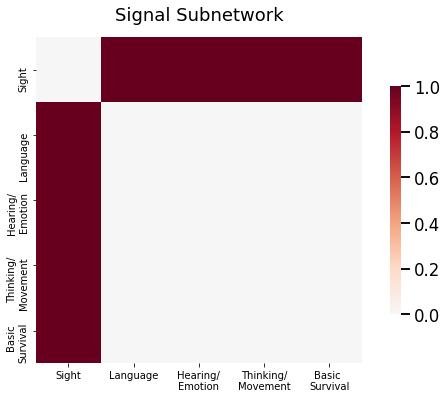

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = heatmap(E, title="Signal Subnetwork", ax = ax,
            xticklabels=[0.5, 1.5, 2.5, 3.5, 4.5], yticklabels=[0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_xticklabels(nodenames);
ax.set_yticklabels(nodenames);

Now that you are familiar with the signal subnetwork $\mathcal S$, you can formally define the signal subnetwork model. For each random pair $(\mathbf A^{(m)}, y_m)$ of your $M$ total pairs, you first obtain a "class assignment" die with $Y$ total sides. For a given face of the dice $y$, the probability that the dice lands on side $Y$ is $\pi_y$. You flip the class assignment die, and if it lands on side $y$, then $\mathbf y_m$ takes the value $y$. Next, for each edge $(i,j)$ which is not in the signal subnetwork $\mathcal S$, you obtain a "non-signal" coin which has a probability of $p_{ij}$ of landing on heads and $1 - p_{ij}$ of landing on tails. The edge $\mathbf a_{ij}$ exists if the coin lands on heads and does not exist if the coin lands on tails. Finally, for each edge $(i, j)$ which is in the signal subnetwork $\mathcal S$, you check which class $\mathbf y_m$ indicates. If $\mathbf y_m$ is class $y$, you obtain a "signal" coin which has a probability of $p_{ij}^y$ of landing on heads, and a probability of $1 - p_{ij}^y$ of landing on tails. The edge $\mathbf a_{ij}$ exists if the coin lands on heads and does not exist if the coin lands on tails. In summary, say that a collection of random network/covariate pairs $\left\{(\mathbf A^{(1)}, \mathbf y_1), ..., (\mathbf A^{(M)}, \mathbf y_M)\right\}$ with $n$ nodes is $SSN_n(\pi_1, ..., \pi_Y, P^1, ..., P^Y, \mathcal S)$ if the following three conditions hold:
1. For every edge $(i, j)$ which is in the signal subnetwork $\mathcal S$, then there exist at least two classes $y$ and $y'$ where $p_{ij}^y \neq p_{ij}^{y'}$.
2. For every edge $(i, j)$ which is not in the signal subnetwork $\mathcal S$, then every edge probability $p_{ij}=p_{ij}^1 =...= p_{ij}^Y$. 
3. conditional on the class $\mathbf y_m$ being $y$, then $\mathbf A^{(m)}$ is $IER_n(P^y)$, where $IER_n(P^y)$ is the {ref}`ch5:ier`.

Next, let's learn how to simulate signal subnetworks.

## How do you simulate samples of $SSN_n(\pi_1, ..., \pi_Y, P^1, ..., P^Y, \mathcal S)$ random networks?

The procedure below will produce for you a set of networks, $A^{(1)}, ..., A^{(M)}$, which have nodes and edges, where the underlying random networks $\left\{\mathbf A^{(1)},..., \mathbf A^{(M)}\right\}$ are $SSN_{n,M}(\pi_1,..., \pi_Y, P^1,..., P^Y, \mathcal S)$ random networks:

```{admonition} Simulating a sample of $SSN_{n,M}(\pi_1,..., \pi_Y, P^1,..., P^Y, \mathcal S)$ random networks
1. Determine a set of signal edges, $\mathcal S$.
2. Determine a set of probability matrices, $\left\{P^1,..., P^Y\right\}$, where each entry $p_{ij}^{y}$ is a probability for each of the $Y$ total classes. These probability matrices should differ only in entries $p_{ij}^y$ where the $(i,j)$ edge is a signal edge from $\mathcal S$.
3. Determine a number of networks, $M$.
4. Determine a length-$Y$ probability vector $\vec\pi$, where each entry $\pi_i$ is a probability for class $i$, for each of the $Y$ classes.
5. Obtain a dice with $Y$ sides, that has a $\pi_y$ chance of landing on the $y$ side.
6. For $m$ in $1$ to $M$:
    * Flip the $Y$-sided die, and if it lands on side $y$, assign the item $m$ to class $y$.
    * Simulate an adjacency matrix $A^{(m)}$, using the procedure for an $IER_n(P^{(y)})$ network.
7. The adjacency matrices you produce, $\left\{A^{(1)},...,A^{(M)}\right\}$, are a sample of $SSN_{n,M}(\pi_1,...,\pi_Y, P^1,...,P^Y, \mathcal S)$ random networks.
```



## References

For more technical depth on the signal subgraph model, check out the paper {cite:p}`Vogelstein2013Jul`. 

```{bibliography}
:filter: docname in docnames
:style: unsrt
```